# Customer Segmentation
- Customers who use your platform have different needs and they have their own different profile (a company must adapt their actions depending on that). 
- If you want to increase retention rate, you can do segmentation based on churn probability and take actions. 
- One segmentation method we will use is RFM

## What is RFM?
- **R**: Recency 
- **F**: Frequency
- **M**: Monetary Value (aka Revenue)

Theoretically, companies will have segments like the following:
1. Low Value: Customers less active than others, not frequent visitors/buyers. Generates very low maybe negative revenue. 
2. Mid Value: Fairly frequent and generate moderate revenue. 
3. High Value: The group we don't want to lose. High revenue and frequency and low inactivity. 

# Recency Clusters

- Objective: Find out the most recent purchase date of each customer and see how many days they are inactive for. After having number of inactive days for each customer, we will apply K-means clustering to assign customers a recency score. 

In [70]:
import pandas as pd

In [71]:
main_df = pd.read_csv('./datasets/OnlineRetail.csv')
main_df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom

In [72]:
main_df['InvoiceDate'] = pd.to_datetime(main_df['InvoiceDate'])

In [73]:
#UK data only
df = main_df[main_df['Country'] == 'United Kingdom']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [74]:
#sanity
df['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [75]:
#sanity check
df['Country'].value_counts()

United Kingdom    495478
Name: Country, dtype: int64

In [76]:
#create a df with unique customer id for the uk
tx_user = pd.DataFrame(df['CustomerID'].unique())
tx_user.head()

0
0  17850.0
1  13047.0
2  13748.0
3  15100.0
4  15291.0

In [77]:
tx_user.columns = ['CustomerID']

In [78]:
#3,951 unique customers from the UK
tx_user.shape

(3951, 1)

In [79]:
#get the max purchase date of a customer and create a df
tx_max_purchase = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
tx_max_purchase.head()

CustomerID         InvoiceDate
0     12346.0 2011-01-18 10:17:00
1     12747.0 2011-12-07 14:34:00
2     12748.0 2011-12-09 12:20:00
3     12749.0 2011-12-06 09:56:00
4     12820.0 2011-12-06 15:12:00

In [80]:
#changing column names
tx_max_purchase.columns = ['CustomerID', 'MaxPurchaseDate']

In [81]:
tx_max_purchase.head()

CustomerID     MaxPurchaseDate
0     12346.0 2011-01-18 10:17:00
1     12747.0 2011-12-07 14:34:00
2     12748.0 2011-12-09 12:20:00
3     12749.0 2011-12-06 09:56:00
4     12820.0 2011-12-06 15:12:00

In [82]:
#we are calculating recency (in days)
# assuming the most recent ourchase is today
tx_max_purchase['Recency'] = (tx_max_purchase['MaxPurchaseDate'].max() - tx_max_purchase['MaxPurchaseDate']).dt.days

In [83]:
tx_max_purchase.head()

CustomerID     MaxPurchaseDate  Recency
0     12346.0 2011-01-18 10:17:00      325
1     12747.0 2011-12-07 14:34:00        1
2     12748.0 2011-12-09 12:20:00        0
3     12749.0 2011-12-06 09:56:00        3
4     12820.0 2011-12-06 15:12:00        2

In [84]:
#merge this dataframe to our new user dataframe
tx_user = pd.merge(tx_user, tx_max_purchase[['CustomerID','Recency']], on='CustomerID')
tx_user.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       31
2     13748.0       95
3     15100.0      329
4     15291.0       25

In [85]:
tx_user.shape

(3950, 2)

In [86]:
#lets get a summary of our recency 
tx_user['Recency'].describe()

count    3950.000000
mean       90.778481
std       100.230349
min         0.000000
25%        16.000000
50%        49.000000
75%       142.000000
max       373.000000
Name: Recency, dtype: float64

In [87]:
#lets plot a distribution chart of our recency 
import chart_studio.plotly.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go

In [88]:
#plotting recency historgram 
plot_data = [
    go.Histogram(
    x = tx_user['Recency']
    )
]

plot_layout = go.Layout(
title = 'Recency'
)

fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

# K- Means Clustering Time!
- We are going to implement K-means clustering to assign a recency score. 
- Note: K-Means does not find the optimal number of clusters for us
- How can we tackle this issue? 
- Solution: Apply the Elbow method to find the number for optimal inertia.

In [89]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

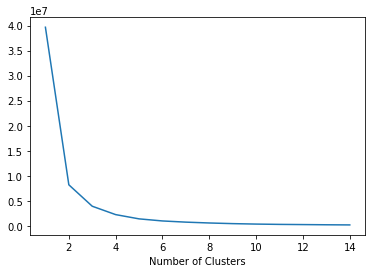

In [90]:
#creating inertia graph 
sse = {}

#creating recency pandas series 
tx_recency = tx_user[['Recency']]
for k in range(1,15):
    kmeans = KMeans(n_clusters = k, max_iter= 1_000).fit(tx_recency)
    tx_recency['clusters'] = kmeans.labels_
    sse[k] = kmeans.inertia_
    
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel('Number of Clusters')
plt.show()

**Based on this graph, it looks like three is the optimal number of clusters**
- Due to business requirements, we can go ahead and implement three or more clusters
- We will be using 4 for this project

In [91]:
tx_user.head()

CustomerID  Recency
0     17850.0      301
1     13047.0       31
2     13748.0       95
3     15100.0      329
4     15291.0       25

In [92]:
#building clusters 
kmeans = KMeans(n_clusters= 4)
kmeans.fit(tx_user[['Recency']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [93]:
from sklearn.metrics import silhouette_score

In [94]:
#the score is decent (so so)
silhouette_score(tx_user[['Recency']], kmeans.labels_)

0.6204325708893099

In [95]:
#add cluster column to tx_user
tx_user['RecencyCluster'] = kmeans.predict(tx_user[['Recency']])

In [96]:
tx_user.head()

CustomerID  Recency  RecencyCluster
0     17850.0      301               2
1     13047.0       31               1
2     13748.0       95               3
3     15100.0      329               2
4     15291.0       25               1

# Breakdown of order_cluster function

In [97]:
#breaking order_clsuter down to steps
cluster_field_name = 'RecencyCluster'
target_field_name = 'Recency'
df = tx_user
ascending = False

new_cluster_field_name = 'new_' + cluster_field_name
#newclster field name is 'new_RecencyCluster

In [98]:
#returns mean of Recency(in days) grouped by clusters 
df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
df_new

RecencyCluster     Recency
0               0  184.625000
1               1   17.488205
2               2  304.393305
3               3   77.679245

In [99]:
#sorts df based on Recency in descending order 
df_new = df_new.sort_values(by=target_field_name,ascending= False).reset_index(drop=True)
df_new

RecencyCluster     Recency
0               2  304.393305
1               0  184.625000
2               3   77.679245
3               1   17.488205

In [100]:
#sets index column 
# note: recency is grouped by recencycluster (using avg)
df_new['index'] = df_new.index
df_new   

RecencyCluster     Recency  index
0               2  304.393305      0
1               0  184.625000      1
2               3   77.679245      2
3               1   17.488205      3

In [101]:
#merging data frames together
# I want the index column appended based on the recency cluster 
df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
df_final.head()

CustomerID  Recency  RecencyCluster  index
0     17850.0      301               2      0
1     15100.0      329               2      0
2     18074.0      373               2      0
3     16250.0      260               2      0
4     13747.0      373               2      0

In [102]:
#dropping recency cluster 
df_final = df_final.drop([cluster_field_name],axis=1)
df_final.head()

CustomerID  Recency  index
0     17850.0      301      0
1     15100.0      329      0
2     18074.0      373      0
3     16250.0      260      0
4     13747.0      373      0

In [103]:
df_final = df_final.rename(columns={"index":cluster_field_name})
df_final
#note: a recency cluster of 0 are customers who didnt shop in a very long time 

CustomerID  Recency  RecencyCluster
0        17850.0      301               0
1        15100.0      329               0
2        18074.0      373               0
3        16250.0      260               0
4        13747.0      373               0
...          ...      ...             ...
3945     15942.0      133               1
3946     14143.0      133               1
3947     16147.0      133               1
3948     15149.0      133               1
3949     15776.0      132               1

[3950 rows x 3 columns]

In [104]:
# #function for ordering cluster numbers
# def order_cluster(cluster_field_name, target_field_name,df,ascending):
#     new_cluster_field_name = 'new_' + cluster_field_name
#     df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
#     df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
#     df_new['index'] = df_new.index
#     df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
#     df_final = df_final.drop([cluster_field_name],axis=1)
#     df_final = df_final.rename(columns={"index":cluster_field_name})
#     return df_final

# tx_user = order_cluster('RecencyCluster', 'Recency',tx_user,False)

In [105]:
tx_user = df_final

In [106]:
tx_user.groupby('RecencyCluster')['Recency'].describe()
#note recency cluster of 0 indicates no loyalty and 3 indicates high loyalty

count        mean        std    min     25%    50%     75%  \
RecencyCluster                                                                
0                478.0  304.393305  41.183489  245.0  266.25  300.0  336.00   
1                568.0  184.625000  31.753602  132.0  156.75  184.0  211.25   
2                954.0   77.679245  22.850898   48.0   59.00   72.5   93.00   
3               1950.0   17.488205  13.237058    0.0    6.00   16.0   28.00   

                  max  
RecencyCluster         
0               373.0  
1               244.0  
2               131.0  
3                47.0

In [107]:
tx_user.groupby('RecencyCluster')['Recency'].mean().reset_index()

RecencyCluster     Recency
0               0  304.393305
1               1  184.625000
2               2   77.679245
3               3   17.488205

# Frequency Clusters 
- We need to find the total number orders for each customer
- First, we calculate this and see how frequency looks like in our customer database. 

In [108]:
df = pd.read_csv('./datasets/OnlineRetail.csv')
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

    InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/10 8:26       2.55     17850.0  United Kingdom  
1  12/1/10 8:26       3.39     17850.0  United Kingdom  
2  12/1/10 8:26       2.75     17850.0  United Kingdom  
3  12/1/10 8:26       3.39     17850.0  United Kingdom  
4  12/1/10 8:26       3.39     17850.0  United Kingdom

In [109]:
#saving to uk.csv 
df = df[df['Country'] == 'United Kingdom']
df['Country'].value_counts()

United Kingdom    495478
Name: Country, dtype: int64

In [110]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [111]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [112]:
df.to_csv('./datasets/UK.csv')

In [113]:
#lets get the frequency of each customer by counting invoice date 
tx_frequency = df.groupby('CustomerID')['InvoiceDate'].count().reset_index()
tx_frequency.head()

CustomerID  InvoiceDate
0     12346.0            2
1     12747.0          103
2     12748.0         4642
3     12749.0          231
4     12820.0           59

In [114]:
#renaming columns
tx_frequency.columns = ['CustomerID', 'Frequency']
tx_frequency.head()

CustomerID  Frequency
0     12346.0          2
1     12747.0        103
2     12748.0       4642
3     12749.0        231
4     12820.0         59

In [115]:
#adding frquecny data to tx_user
tx_user = pd.merge(tx_user, tx_frequency, on = 'CustomerID')
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency
0     17850.0      301               0        312
1     15100.0      329               0          6
2     18074.0      373               0         13
3     16250.0      260               0         24
4     13747.0      373               0          1

In [116]:
tx_user['Frequency'].describe()

count    3950.000000
mean       91.614684
std       220.557389
min         1.000000
25%        17.000000
50%        41.000000
75%       101.000000
max      7983.000000
Name: Frequency, dtype: float64

In [117]:
#plotting histogram of frequency 
plot_data = [
    go.Histogram(
        x = tx_user[tx_user['Frequency']< 1_000]['Frequency']
        #masking does work!
        #equivalent to tx_user.query('Frequency < 1000')['Frequency']
    )
]

plot_layout = go.Layout(
title = 'Frequency'
)

fig = go.Figure(data = plot_data, layout= plot_layout)

pyoff.iplot(fig)

## Frequency Cluster Time
- Without doing the elbow graph, we're gonna assume there are 4 clusters for frequency

In [118]:
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency
0     17850.0      301               0        312
1     15100.0      329               0          6
2     18074.0      373               0         13
3     16250.0      260               0         24
4     13747.0      373               0          1

In [119]:
#creating the funtuon now since we're going to use it many times
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

In [120]:
#instatiating clusters at 4
kmeans = KMeans(n_clusters= 4)

#fitting clusters for frequency
kmeans.fit(tx_user[['Frequency']])

#creating new column to tx_user called FrequencyCluster
tx_user['FrequencyCluster'] = kmeans.predict(tx_user[['Frequency']])
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster
0     17850.0      301               0        312                 2
1     15100.0      329               0          6                 0
2     18074.0      373               0         13                 0
3     16250.0      260               0         24                 0
4     13747.0      373               0          1                 0

In [121]:
tx_user.groupby('FrequencyCluster')['Frequency'].mean()

FrequencyCluster
0      49.525744
1    5917.666667
2     331.221445
3    1313.136364
Name: Frequency, dtype: float64

In [122]:
#order the frequency cluster
tx_user = order_cluster('FrequencyCluster', 'Frequency',tx_user,True)

In [123]:
#look at the details of each feqeuency cluster 
tx_user.groupby('FrequencyCluster')['Frequency'].describe()


#note: in terms of frequemcy clusters, we set it to ascending order since the higher the better
#whereas for recency, its set to descending since the lower the recency, the better it is for the company 

count         mean          std     min     25%     50%  \
FrequencyCluster                                                             
0                 3496.0    49.525744    44.954212     1.0    15.0    33.0   
1                  429.0   331.221445   133.856510   191.0   228.0   287.0   
2                   22.0  1313.136364   505.934524   872.0   988.5  1140.0   
3                    3.0  5917.666667  1805.062418  4642.0  4885.0  5128.0   

                     75%     max  
FrequencyCluster                  
0                   73.0   190.0  
1                  399.0   803.0  
2                 1452.0  2782.0  
3                 6555.5  7983.0

# Revenue Time!

In [124]:
#remember our uk data?
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom

In [125]:
#calcuating the revenue for each customer 
df['Revenue'] = df['UnitPrice']* df['Quantity']
df.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Revenue  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom    15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom    22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom    20.34

In [126]:
#return sum of revenue based on customer id 
tx_revenue = df.groupby('CustomerID')['Revenue'].sum().reset_index()

In [127]:
#merge it with the main dataframe 
tx_user = pd.merge(tx_user, tx_revenue, on = 'CustomerID')
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue
0     17850.0      301               0        312                 1   5288.63
1     15808.0      305               0        210                 1   3724.77
2     13047.0       31               3        196                 1   3079.10
3     14688.0        7               3        359                 1   5107.38
4     16029.0       38               3        274                 1  50992.61

In [128]:
tx_user.shape

(3950, 6)

In [129]:
tx_user['Revenue'].describe()

count      3950.000000
mean       1713.385669
std        6548.608224
min       -4287.630000
25%         282.255000
50%         627.060000
75%        1521.782500
max      256438.490000
Name: Revenue, dtype: float64

In [130]:
#plotting the revenue data 
plot_data = [
    go.Histogram(
    x = tx_user[tx_user['Revenue']< 5_000]['Revenue']
    )
]

plot_layout = go.Layout(
    title = 'Monetary Value'
)

fig = go.Figure(data = plot_data, layout = plot_layout)
pyoff.iplot(fig)

**Note** : We have customers with negative revenue as well 

# Cluster Time for Revenue

In [131]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(tx_user[['Revenue']])

tx_user['RevenueCluster'] = kmeans.predict(tx_user[['Revenue']])
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     15808.0      305               0        210                 1   3724.77   
2     13047.0       31               3        196                 1   3079.10   
3     14688.0        7               3        359                 1   5107.38   
4     16029.0       38               3        274                 1  50992.61   

   RevenueCluster  
0               0  
1               3  
2               3  
3               0  
4               2

In [132]:
#order the cluster numbers
tx_user = order_cluster('RevenueCluster', 'Revenue',tx_user,True)
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  
0               1  
1               1  
2               1  
3               1  
4               1

In [133]:
#detailed summary of the datafrmae 
tx_user.groupby('RevenueCluster')['Revenue'].describe()

count           mean           std        min         25%  \
RevenueCluster                                                               
0               3687.0     907.254414    921.910820   -4287.63     263.115   
1                234.0    7760.699530   3637.173671    4330.67    5161.485   
2                 27.0   43070.445185  15939.249588   25748.35   28865.490   
3                  2.0  221960.330000  48759.481478  187482.17  204721.250   

                      50%         75%        max  
RevenueCluster                                    
0                  572.56    1258.220    4314.72  
1                 6549.38    9142.305   21535.90  
2                36351.42   53489.790   88125.38  
3               221960.33  239199.410  256438.49

# Checkpoint
- We have clusters for the three main components (Recency, Frequency, Revenue)
- Let's compute the overall score from RFR

In [134]:
tx_user.head(2)

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster  Revenue  \
0     17850.0      301               0        312                 1  5288.63   
1     14688.0        7               3        359                 1  5107.38   

   RevenueCluster  
0               1  
1               1

In [135]:
tx_user['OverallScore'] = tx_user['RecencyCluster']+tx_user['FrequencyCluster']+tx_user['RevenueCluster']
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  OverallScore  
0               1             2  
1               1             5  
2               1             5  
3               1             5  
4               1             5

In [136]:
#lets get the description statistics (mean)
tx_user.groupby('OverallScore')['Recency', 'Frequency', 'Revenue'].mean()

Recency    Frequency        Revenue
OverallScore                                        
0             304.584388    21.995781     303.339705
1             185.362989    32.596085     498.087546
2              78.991304    46.963043     868.082991
3              20.689610    68.419590    1091.416414
4              14.892617   271.755034    3607.097114
5               9.662162   373.290541    9136.946014
6               7.740741   876.037037   22777.914815
7               1.857143  1272.714286  103954.025714
8               1.333333  5917.666667   42177.930000

**Note**
- Customers with a score of 8 is the best and 0 is the worst 

|Customer Value|Overall Score Range|
|--|--|
|Low|0,1,2|
|Mid Value|3,4|
|High Value|5,6,7,8|

In [137]:
#nowing these scores, let's name them on our dataframe 
#first step is to assume all customers are low vlaue 
tx_user['Segment'] = 'Low-Value'
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  OverallScore    Segment  
0               1             2  Low-Value  
1               1             5  Low-Value  
2               1             5  Low-Value  
3               1             5  Low-Value  
4               1             5  Low-Value

In [138]:
#time to segment mid value and high value 

#for users with overall score of 2 or greater, name it mid value under segment column
tx_user.loc[tx_user['OverallScore'] >= 3, 'Segment'] = 'Mid-Value'

tx_user.loc[tx_user['OverallScore'] >= 5, 'Segment'] = 'High-Value'

In [139]:
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  OverallScore     Segment  
0               1             2   Low-Value  
1               1             5  High-Value  
2               1             5  High-Value  
3               1             5  High-Value  
4               1             5  High-Value

# Data Visualizations Time!

In [145]:
tx_user[['Frequency', 'Revenue', 'Recency']].describe()

Frequency        Revenue      Recency
count  3950.000000    3950.000000  3950.000000
mean     91.614684    1713.385669    90.778481
std     220.557389    6548.608224   100.230349
min       1.000000   -4287.630000     0.000000
25%      17.000000     282.255000    16.000000
50%      41.000000     627.060000    49.000000
75%     101.000000    1521.782500   142.000000
max    7983.000000  256438.490000   373.000000

## Graph 1: Frequency on Revenue 

In [144]:
#Revenue vs Frequency

#I used the .describe methd to determine range of graph
tx_graph = tx_user.query("Revenue < 50_000 and Frequency < 2_000")

plot_data = [
    go.Scatter(
        #low value dots
        x=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        #mid value dots
        x=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        #high vlaue dots
        x=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Graph 2: Recency on Revenue

In [146]:
tx_graph = tx_user.query("Revenue < 50000 and Recency < 300")

plot_data = [
    go.Scatter(
        #low value
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
            #mid value
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
            #high value
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)


## Graph 3: Recency on Frequency 

In [149]:
# Revenue vs Frequency
tx_graph = tx_user.query("Frequency < 2_000 and Recency < 300")

plot_data = [
    go.Scatter(
        #low value
        x=tx_graph.query("Segment == 'Low-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
            #mid value
        x=tx_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=tx_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
            #high value
        x=tx_graph.query("Segment == 'High-Value'")['Recency'],
        y=tx_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

## Main Strategies (between Retention and Frequency)
- High Value: Improve Retention 
- Mid Value: Improve Retention and Increase Frequency
- Low Value: Increase Frequency

In [150]:
#lets save tx_user just in case
tx_user.head()

CustomerID  Recency  RecencyCluster  Frequency  FrequencyCluster   Revenue  \
0     17850.0      301               0        312                 1   5288.63   
1     14688.0        7               3        359                 1   5107.38   
2     13767.0        1               3        399                 1  16945.71   
3     15513.0       30               3        314                 1  14520.08   
4     14849.0       21               3        392                 1   7904.28   

   RevenueCluster  OverallScore     Segment  
0               1             2   Low-Value  
1               1             5  High-Value  
2               1             5  High-Value  
3               1             5  High-Value  
4               1             5  High-Value

In [151]:
tx_user.to_csv('./datasets/uk_clusters.csv')